# SAM
<a target="blank" href="https://colab.research.google.com/github/mora-bprs/SAM-model/blob/thuva/fastSAM.ipynb">
 <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Initialize

In [6]:
import cv2
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import gdown
import shutil


print(f"PyTorch v{torch.__version__}")
print(f"Torchvision v{torchvision.__version__}")
COLAB = False # edit this to false in local environments
CUDA = torch.cuda.is_available()
MPS = torch.backends.mps.is_available()
print(f"CUDA Available: {CUDA}")
print(f"MPS Available: {MPS}")
device = "cuda" if CUDA else "cpu"
ROOT = os.getcwd() if not COLAB else "/content"
print("CWD:", ROOT)

PyTorch v2.3.0
Torchvision v0.18.0
CUDA Available: False
MPS Available: True
CWD: /Users/tony/dev/SAM-model


## Dataset Setup

In [7]:
# if COLAB:
#     # downloading box dataset "https://drive.google.com/file/d/1iWaDuDQKftRDZ_poWyEua7j6_leDhDQc/view?usp=sharing"
#     !gdown 1iWaDuDQKftRDZ_poWyEua7j6_leDhDQc
#     # unzipping
#     !unzip box_train.zip
#     dataset_path = "/content/train"
# else:
gdown.download("https://drive.google.com/uc?id=1iWaDuDQKftRDZ_poWyEua7j6_leDhDQc", "box_train.zip", quiet=False)
if os.path.exists("train"):
    shutil.rmtree("train", ignore_errors=False)
!unzip box_train.zip
os.remove("box_train.zip")
DATASET_PATH = f"{ROOT}/train"

Downloading...
From: https://drive.google.com/uc?id=1iWaDuDQKftRDZ_poWyEua7j6_leDhDQc
To: /Users/tony/dev/SAM-model/box_train.zip
100%|██████████| 4.76M/4.76M [00:01<00:00, 2.67MB/s]

Archive:  box_train.zip
  inflating: train/box_0.jpg         
  inflating: train/box_1.jpg         
  inflating: train/box_100.jpg       
  inflating: train/box_101.jpg       
  inflating: train/box_102.jpg       
  inflating: train/box_103.jpg       
  inflating: train/box_104.jpg       
  inflating: train/box_105.jpg       
  inflating: train/box_106.jpg       
  inflating: train/box_107.jpg       
  inflating: train/box_108.jpg       
  inflating: train/box_109.jpg       
  inflating: train/box_11.jpg        
  inflating: train/box_110.jpg       
  inflating: train/box_111.jpg       
  inflating: train/box_112.jpg       
  inflating: train/box_113.jpg       
  inflating: train/box_114.jpg       
  inflating: train/box_115.jpg       
  inflating: train/box_116.jpg       
  inflating: train/box_117.jpg       
  inflating: train/box_118.jpg       
  inflating: train/box_119.jpg       
  inflating: train/box_120.jpg       
  inflating: train/box_121.jpg       
  inflating: train/box_122

In [8]:
# download FastSAM and weights
RESET_FASTSAM = False
if RESET_FASTSAM or not os.path.exists("FastSAM"):
    if os.path.exists("FastSAM"):
        shutil.rmtree("FastSAM", ignore_errors=False)
    !git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
    !wget https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt


In [9]:
%pip install -r FastSAM/requirements.txt
# %pip install git+https://github.com/openai/CLIP.git

Note: you may need to restart the kernel to use updated packages.


### Download the checkpoints

Two model versions of the model are available with different sizes.
- `default` or `FastSAM` - [https://drive.google.com/file/d/1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv/view](https://drive.google.com/file/d/1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv/view)
- `FastSAM-s` - [https://drive.google.com/file/d/10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV/view](https://drive.google.com/file/d/10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV/view)

In [10]:
# if COLAB:
#     # Download weights for 'default' checkpoint
#     !gdown 1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv
#     # Download weights for 'FastSAM-s' checkpoint
#     !gdown 10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV
# else:
RESET_FASTSAM = False
if RESET_FASTSAM:
    if os.path.exists("FastSAM-s.pt"):
        os.remove("FastSAM-s.pt")
    if os.path.exists("FastSAM-x.pt"):
        os.remove("FastSAM-x.pt")
if not os.path.exists("FastSAM-s.pt"):
    gdown.download("https://drive.google.com/uc?id=10XmSj6mmpmRb8NhXbtiuO9cTTBwR_9SV", "FastSAM-s.pt", quiet=False)
if not os.path.exists("FastSAM-x.pt"):
    gdown.download("https://drive.google.com/uc?id=1m1sjY4ihXBU1fZXdQ-Xdj-mDltW-2Rqv", "FastSAM-x.pt", quiet=False)

___

## Setup

In [11]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## Example image

## Using pretrained model

In [12]:
from fastsam import FastSAM, FastSAMPrompt

fast_sam_checkpoint = f"{ROOT}/FastSAM-x.pt"
fast_sam_s_checkpoint = f"{ROOT}/FastSAM-s.pt"
model_fast_sam = FastSAM(fast_sam_checkpoint)
model_fast_sam_s = FastSAM(fast_sam_s_checkpoint)

## Example image

In [13]:
def list_image_files(directory):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']  # Add more if needed
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_files.append(os.path.join(root, file))
    return image_files

image_paths = list_image_files(DATASET_PATH)
sample_img_path = image_paths[40]
image = cv2.imread(sample_img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

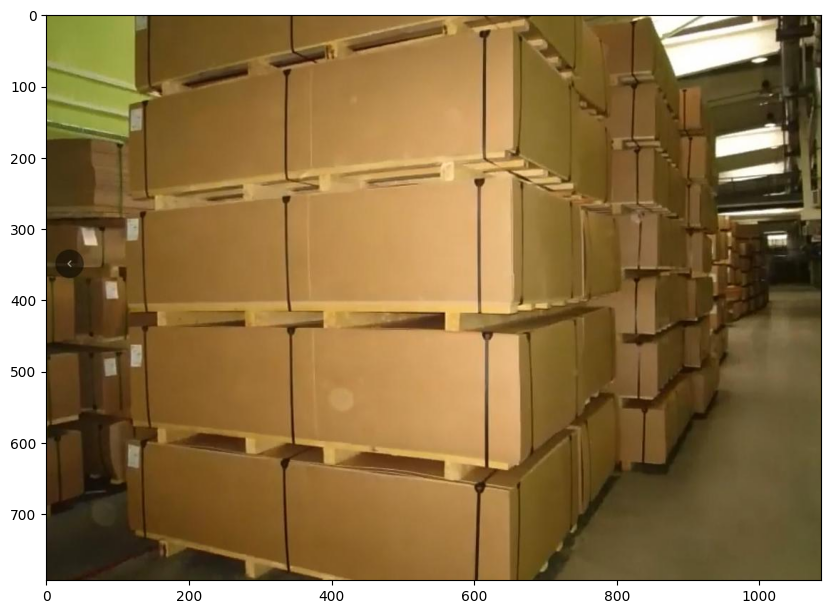

In [14]:
def plot_image(image):
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  plt.axis('on')
  plt.show()

plot_image(image)

In [15]:
image_height, image_width, _ = image.shape
print(f"Image resolution: {image_width}x{image_height}")
center_point_coords = [ int(image_width/2), int(image_height/2)]
input_point = np.array([center_point_coords])
input_label = np.array([1])

Image resolution: 1087x793


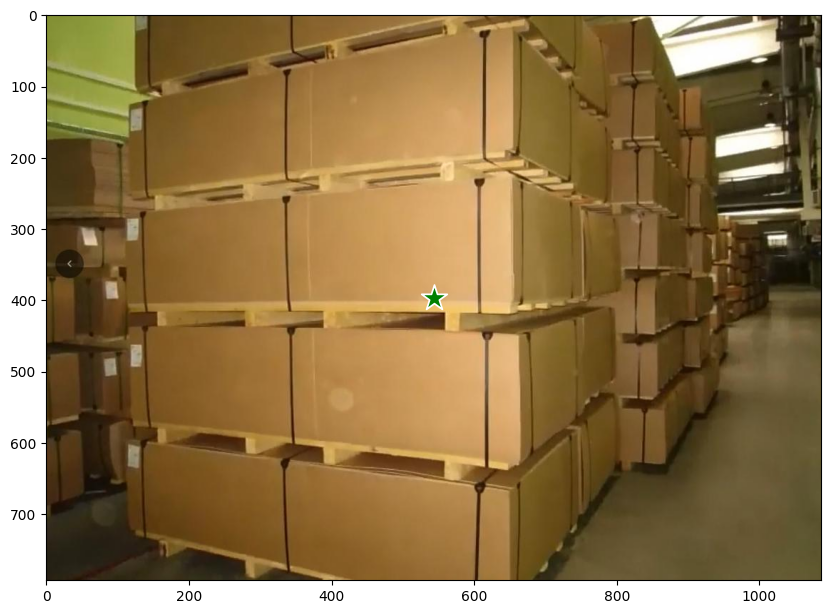

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

### Mask prediction

In [17]:
fast_sam_predictor = model_fast_sam(image, device=device, retina_masks=True, imgsz=930, conf=0.4, iou=0.9,)
fast_sam_prompt_process = FastSAMPrompt(image, fast_sam_predictor, device=device)
fast_sam_s_predictor = model_fast_sam_s(image, device=device, retina_masks=True, imgsz=930, conf=0.4, iou=0.9,)
fast_sam_s_prompt_process = FastSAMPrompt(image, fast_sam_s_predictor, device=device)


WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
0: 704x960 41 objects, 1091.7ms
Speed: 4.5ms preprocess, 1091.7ms inference, 74.1ms postprocess per image at shape (1, 3, 960, 960)

WARNING ⚠️ imgsz=[930] must be multiple of max stride 32, updating to [960]
0: 704x960 37 objects, 224.7ms
Speed: 2.1ms preprocess, 224.7ms inference, 75.8ms postprocess per image at shape (1, 3, 960, 960)


In [18]:
# everything prompt
# mask = fast_sam_prompt_process.everything_prompt()
# bbox default shape [0,0,0,0] -> [x1,y1,x2,y2]
# ann = fast_sam_prompt_process.box_prompt(bboxes=[[200, 200, 300, 300]])
# text prompt
# ann = fast_sam_prompt_process.text_prompt(text='a photo of a box')

In [19]:
# point prompt
# points default [[0,0]] [[x1,y1],[x2,y2]]
# point_label default [0] [1,0] 0:background, 1:foreground
mask = fast_sam_prompt_process.point_prompt(points=[center_point_coords], pointlabel=[1])
ANNOTATED_PATH = f"{ROOT}/annotate/box.jpg"
fast_sam_prompt_process.plot(annotations=mask,output_path=ANNOTATED_PATH)

In [20]:
mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [21]:
def plot_mask_with_score(image, title,mask, input_point, input_label ):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {title}", fontsize=18)
    plt.axis('on')
    plt.show()

In [22]:
input_point = np.array([center_point_coords])
input_label = np.array([1])

In [23]:
plot_mask_with_score(image, "FastSAM output", mask, input_point, input_label )

In [24]:
sample_mask = mask
sample_mask

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [25]:
sample_mask.shape

(1, 793, 1087)

In [26]:
image.shape

(793, 1087, 3)

The mask and the image are not in the correct matching dimensions. We have to map this one.


In [27]:
reshaped_mask = np.transpose(sample_mask, (1, 2, 0))
reshaped_mask.shape

(793, 1087, 1)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_square(mask):
    # Find the indices where the mask is True
    true_indices = np.argwhere(mask)

    # Get the bounding box of the True region
    top_left = np.min(true_indices, axis=0)
    bottom_right = np.max(true_indices, axis=0)

    # Calculate the width and height of the bounding box
    width = bottom_right[1] - top_left[1]
    height = bottom_right[0] - top_left[0]

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Plot the mask
    ax.imshow(mask, cmap='gray')

    # Create a rectangle patch
    rect = patches.Rectangle((top_left[1], top_left[0]), width, height, linewidth=1, edgecolor='r', facecolor='none')

    # Add the rectangle patch to the axis
    ax.add_patch(rect)

    # Show the plot
    plt.show()

# Example usage:
# Assuming you have your mask array named "mask"
plot_square(reshaped_mask)


In [29]:
import numpy as np

def get_bounding_box_coordinates(mask):
    # Find the indices where the mask is True
    true_indices = np.argwhere(mask)

    # Get the bounding box of the True region
    top_left = np.min(true_indices, axis=0)
    bottom_right = np.max(true_indices, axis=0)

    # Calculate the width and height of the bounding box
    width = bottom_right[1] - top_left[1]
    height = bottom_right[0] - top_left[0]

    # Calculate the coordinates of the corners
    top_right = (top_left[1] + width, top_left[0])
    bottom_left = (top_left[1], top_left[0] + height)
    bottom_right = (top_left[1] + width, top_left[0] + height)

    return top_left, top_right, bottom_left, bottom_right

# Example usage:
# Assuming you have your mask array named "mask"
top_left, top_right, bottom_left, bottom_right = get_bounding_box_coordinates(reshaped_mask)
print("Top left:", top_left)
print("Top right:", top_right)
print("Bottom left:", bottom_left)
print("Bottom right:", bottom_right)


Top left: [ 0 37  0]
Top right: (967, 0)
Bottom left: (37, 792)
Bottom right: (967, 792)


In [30]:
import numpy as np

def get_bounding_box_coordinates_updated(mask):
    # Find the indices where the mask is True
    true_indices = np.argwhere(mask)

    # Get the bounding box of the True region
    top_left = np.min(true_indices, axis=0)
    bottom_right = np.max(true_indices, axis=0)

    # Calculate the width and height of the bounding box
    width = bottom_right[1] - top_left[1]
    height = bottom_right[0] - top_left[0]

    # Calculate the coordinates of the corners
    top_right = (top_left[1] + width, top_left[0])
    bottom_left = (top_left[1], top_left[0] + height)
    bottom_right = (top_left[1] + width, top_left[0] + height)

    top_left[0] = top_right[0] - (bottom_right[0]-bottom_left[0])
    top_left[1] = (top_right[1]-bottom_right[1]) + bottom_left[1]

    return top_left, top_right, bottom_left, bottom_right

# Example usage:
# Assuming you have your mask array named "mask"
top_left, top_right, bottom_left, bottom_right = get_bounding_box_coordinates_updated(sample_mask)
print("Top left:", top_left)
print("Top right:", top_right)
print("Bottom left:", bottom_left)
print("Bottom right:", bottom_right)


Top left: [ 0  0 37]
Top right: (792, 0)
Bottom left: (0, 0)
Bottom right: (792, 0)


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def annotate_square_corners(image, top_left, top_right, bottom_left, bottom_right, save_path):
    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Plot the original image
    ax.imshow(image)

    # Annotate the corners
    ax.plot(top_left[0], top_left[1], 'ro')          # Top Left corner
    ax.plot(top_right[0], top_right[1], 'go')        # Top Right corner
    ax.plot(bottom_left[0], bottom_left[1], 'bo')    # Bottom Left corner
    ax.plot(bottom_right[0], bottom_right[1], 'yo')  # Bottom Right corner

    # Show the plot
    plt.show()

    # Save the plot to the specified path
    plt.savefig(save_path)

    # Close the plot to release resources
    # plt.close()

# Example usage:
# Assuming you have your original image as "image" and the corners' coordinates obtained from get_square_corners
top_left, top_right, bottom_left, bottom_right = get_bounding_box_coordinates_updated(reshaped_mask)
annotate_square_corners(image, top_left, top_right, bottom_left, bottom_right, "/content/sample_image_annotated.jpg")


FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_image_annotated.jpg'

: 

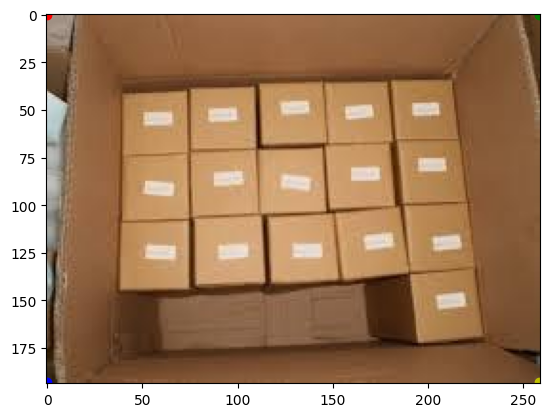

In [ ]:
import matplotlib.pyplot as plt

def annotate_square_corners(image, top_left, top_right, bottom_left, bottom_right, save_path):
    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Plot the original image
    ax.imshow(image)

    # Annotate the corners
    ax.plot(top_left[0], top_left[1], 'ro')          # Top Left corner
    ax.plot(top_right[0], top_right[1], 'go')        # Top Right corner
    ax.plot(bottom_left[0], bottom_left[1], 'bo')    # Bottom Left corner
    ax.plot(bottom_right[0], bottom_right[1], 'yo')  # Bottom Right corner

    # Save the plot to the specified path
    plt.savefig(save_path)

    plt.show()

    # Close the plot to release resources
    # plt.close()


# Example usage:
# Assuming you have your image and corner coordinates
top_left, top_right, bottom_left, bottom_right = get_bounding_box_coordinates_updated(reshaped_mask)
annotate_square_corners(image, top_left, top_right, bottom_left, bottom_right, "/content/sample_image_annotated.jpg")


## Pipeline

In [ ]:
def get_box_coordinates_fast_sam(image_path:str,model_path:str, isFastSAM=True, showOriginalImage=False, showPoints=True, showPlotMaskWithHighestScore=True):
  # load image
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # plot original image
  if showOriginalImage:
    plot_image(img)

  # get image dimensions
  img_height, img_width, _ = img.shape

  # get centre point coordinates
  center_point_coords = [ int(img_width/2), int(img_height/2)]
  input_point = np.array([center_point_coords])
  input_label = np.array([1])

  if showPoints:
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.show()


  # draw a rectangle that makes the center point of image

  # generate the mask in the relevant area
  if isFastSAM:
    model_fast_sam = FastSAM(model_path)
    fast_sam_predictor = model_fast_sam(img, device=device, retina_masks=True, imgsz=img_width, conf=0.4, iou=0.9,)
    fast_sam_prompt_process = FastSAMPrompt(img, fast_sam_predictor, device=device)

    # point prompt
    # points default [[0,0]] [[x1,y1],[x2,y2]]
    # point_label default [0] [1,0] 0:background, 1:foreground
    img_mask = fast_sam_prompt_process.point_prompt(points=input_point, pointlabel=input_label)


    # plot_mask_with_score(img, "FastSAM output", img_mask, input_point, input_label )

    # reshape image mask
    # print(img_mask.shape)
    img_mask = np.transpose(img_mask, (1, 2, 0))
    # print(img_mask.shape)

  if showPlotMaskWithHighestScore:
    plot_square(img_mask)

  # get the rectangular boxes
  img_top_left, img_top_right, img_bottom_left, img_bottom_right = get_bounding_box_coordinates_updated(img_mask)

  # get the coordinates of the rectangular bounding box
  annotate_square_corners(img, img_top_left, img_top_right, img_bottom_left, img_bottom_right, "/content/annotated_box_image.jpg")




WARNING ⚠️ imgsz=[355] must be multiple of max stride 32, updating to [384]
0: 160x384 17 objects, 674.5ms
Speed: 1.2ms preprocess, 674.5ms inference, 8.4ms postprocess per image at shape (1, 3, 384, 384)


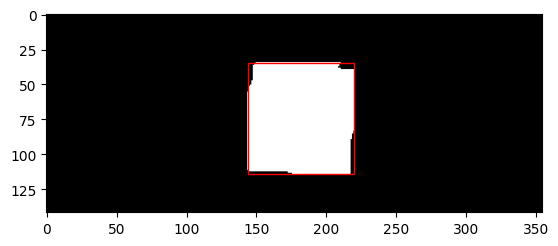

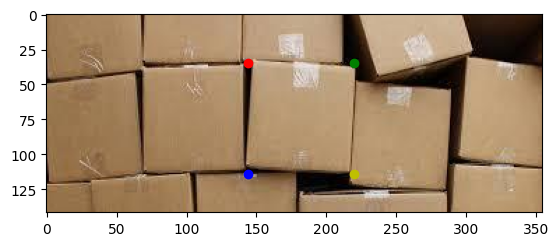

Time taken for operation : 2.986732006072998


In [ ]:
time_list = []

# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(image_paths[5], model_path=fast_sam_checkpoint, isFastSAM=True, showOriginalImage=False, showPoints=False, showPlotMaskWithHighestScore=True)

time_list.append(time.time()-start_time)
print(f"Time taken for operation : {time_list[-1]}")

### Time ; if no images are not shown to the output


WARNING ⚠️ imgsz=[355] must be multiple of max stride 32, updating to [384]
0: 160x384 17 objects, 636.8ms
Speed: 0.8ms preprocess, 636.8ms inference, 8.3ms postprocess per image at shape (1, 3, 384, 384)


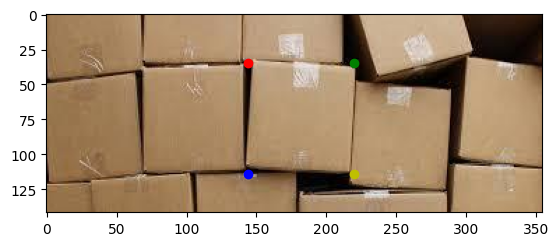

Time taken for operation : 2.241401195526123


In [ ]:
# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(image_paths[5], model_path=fast_sam_checkpoint, isFastSAM=True, showOriginalImage=False, showPoints=False, showPlotMaskWithHighestScore=False)

time_list.append(time.time()-start_time)
print(f"Time taken for operation : {time_list[-1]}")

## Using FAST SAM S model


WARNING ⚠️ imgsz=[355] must be multiple of max stride 32, updating to [384]
0: 160x384 18 objects, 107.3ms
Speed: 0.8ms preprocess, 107.3ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 384)


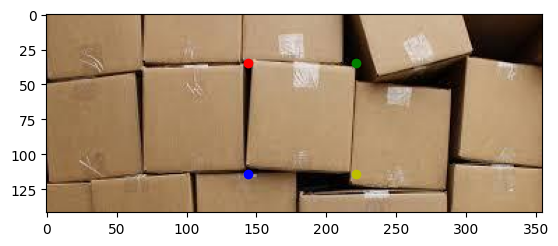

Time taken for operation : 0.5952808856964111


In [ ]:
# test on one image
import time

start_time = time.time()
get_box_coordinates_fast_sam(image_paths[5], model_path=fast_sam_s_checkpoint, isFastSAM=True, showOriginalImage=False, showPoints=False, showPlotMaskWithHighestScore=False)

time_list.append(time.time()-start_time)
print(f"Time taken for operation : {time_list[-1]}")

In [ ]:
################## Have to change this below this line ...

In [ ]:
time_list = []

In [ ]:
output_images_path = "/content/drive/MyDrive/annotated_boxes_fast_sam/"

In [ ]:
try:
  os.makedirs(output_images_path)
except FileExistsError:
  print("folder already exists")

In [ ]:
def get_box_coordinates_updated(image_path:str,showOriginalImage=False, showPoints=True, showMasksWithScores=True, showPlotMaskWithHighestScore=True):
  img_name = image_path.split("/")[-1]
  # load image
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # plot original image
  if showOriginalImage:
    plot_image(img)

  # get image dimensions
  img_height, img_width, _ = img.shape

  # get centre point coordinates
  center_point_coords = [ int(img_width/2), int(img_height/2)]
  input_point = np.array([center_point_coords])
  input_label = np.array([1])

  if showPoints:
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_points(input_point, input_label, plt.gca())
    plt.axis('on')
    plt.show()


  # draw a rectangle that makes the center point of image

  # generate masks in the relevant area
  predictor.set_image(img)

  img_masks, img_masks_scores, img_masks_logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
  )

  if showMasksWithScores:
    for i, (mask, score) in enumerate(zip(img_masks, img_masks_scores)):
        plot_mask_with_score(img, i+1, mask, score, input_point, input_label)


  # get the mask with the highest score
  img_mask_with_highest_score, img_mask_highest_score, img_mask_logits_for_highest_score = get_mask_with_highest_score(img_masks, img_masks_scores, img_masks_logits)

  if showPlotMaskWithHighestScore:
    plot_square(img_mask_with_highest_score)

  # get the rectangular boxes
  img_top_left, img_top_right, img_bottom_left, img_bottom_right = get_bounding_box_coordinates_updated(img_mask_with_highest_score)

  # get the coordinates of the rectangular bounding box

  annotate_square_corners(img, img_top_left, img_top_right, img_bottom_left, img_bottom_right, output_images_path+img_name)

In [ ]:
get_box_coordinates_updated(image_paths[0],showOriginalImage=False, showPoints=False, showMasksWithScores=False, showPlotMaskWithHighestScore=False)


NameError: name 'predictor' is not defined

In [ ]:
updated_time_list = []

In [ ]:
for img_path in image_paths:
  # start_time = time.time()
  get_box_coordinates_updated(img_path,showOriginalImage=False, showPoints=False, showMasksWithScores=False, showPlotMaskWithHighestScore=False)

  # updated_time_list.append(time.time()-start_time)
  # print(f"Time taken for operation : {time_list[-1]}")


In [ ]:
updated_avg_time = sum(updated_time_list)/len(image_paths)
print("Average time for inference :", updated_avg_time, " s")